# Graph network model training for SODAS prediction

This notebook will guide you through graph network model training and inference for predicting the SODAS (structural orderness degree for atomic structures) metric. Before we proceed, make sure to install all the neccessary packages (please see the README file of this repository for installation instructions).

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## Initialize model

The model parameters and complexity (number of weights) are determined here.

In [2]:
from graphite.nn.models import EGCONV_GNN
from graphite.utils import summary

model = EGCONV_GNN(
    dim = 64,
    num_interactions = 3,
    num_species = 1,
    cutoff = 3.5,
)

print(model)
summary(model)

EGCONV_GNN(dim=64, num_interactions=3, num_species=1, cutoff=3.5)


,Layer,Params
0,embed_atm.weight,64
1,atm_bnd_interactions.0.W_src.weight,4096
2,atm_bnd_interactions.0.W_src.bias,64
3,atm_bnd_interactions.0.W_dst.weight,4096
4,atm_bnd_interactions.0.W_dst.bias,64
5,atm_bnd_interactions.0.W_e.weight,12288
6,atm_bnd_interactions.0.W_e.bias,64
7,atm_bnd_interactions.0.norm_x.weight,64
8,atm_bnd_interactions.0.norm_x.bias,64
9,atm_bnd_interactions.0.norm_e.weight,64


## Load training data

The original training data is a set of 1625 FCC Al configurations simulated with MD from 50K to 1200K, converted and stored in PyG (Pytorch-Geometric) graph format such that it's ready for ML training without the hassle of having to do the graph conversion yourself. However, it's 800 MB in size. Here, for demonstration purpose, we will take a smaller subset of the training data, which is stored in the repository.

Note that to read the training data, you might need to have the right versions of PyG and possibily PyTorch. I'm using pyg 2.0.4 and pytorch 1.11.0 in this notebook.

In [3]:
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split

PIN_MEMORY  = True  # related to optimization for training, revert to False if you see any issues
NUM_WORKERS = 4     # related to optimization for training, revert to 1 if you see any issues
BATCH_SIZE  = 16    # adjust this so that each minibatch fits in the (GPU) memory

dataset = torch.load('./data/train/fcc-Al-50-to-1200K-r3.5-small.pt')

ds_train, ds_valid = train_test_split(dataset, train_size=0.9, random_state=12345)

loader_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
loader_valid = DataLoader(ds_valid, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f'Number of train graphs: {len(loader_train.dataset)}')
print(f'Number of valid graphs: {len(loader_valid.dataset)}')

Number of train graphs: 11
Number of valid graphs: 2


## Train the model

In [4]:
LEARN_RATE  = 1e-4
NUM_UPDATES = 1_000    # number of model updates you wish to apply

num_samples = len(ds_train)
num_epochs  = int(NUM_UPDATES/(num_samples/BATCH_SIZE))
print(f'{num_epochs} epochs needed to update the model {NUM_UPDATES} times.')

1454 epochs needed to update the model 1000 times.


In [5]:
def train(loader):
    model.train()
    total_loss = 0.0
    for data in loader:
        optimizer.zero_grad(set_to_none=True)
        data = data.to(device, non_blocking=PIN_MEMORY)
        pred = model(data)
        loss = loss_fn(pred, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def test(loader):
    model.eval()
    total_loss = 0.0
    for data in loader:
        data = data.to(device, non_blocking=PIN_MEMORY)
        pred = model(data)
        loss = loss_fn(pred, data.y)
        total_loss += loss.item()
    return total_loss / len(loader)

The training time depends on the number of model updates you specify.

In [6]:
from tqdm.notebook import trange

optimizer = torch.optim.AdamW(model.parameters(), lr=LEARN_RATE)
device    = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = model.to(device)
loss_fn   = torch.nn.BCELoss()

L_train, L_valid = [], []
with trange(num_epochs) as pbar:
    for _ in pbar:
        loss_train = train(loader_train); L_train.append(loss_train)
        loss_valid = test(loader_valid); L_valid.append(loss_valid)
        pbar.set_postfix(
            loss_train=loss_train,
            loss_valid=loss_valid,
        )

  0%|          | 0/1454 [00:00<?, ?it/s]

## Loss curves

Be aware that the loss curves may not look good with the small dataset.

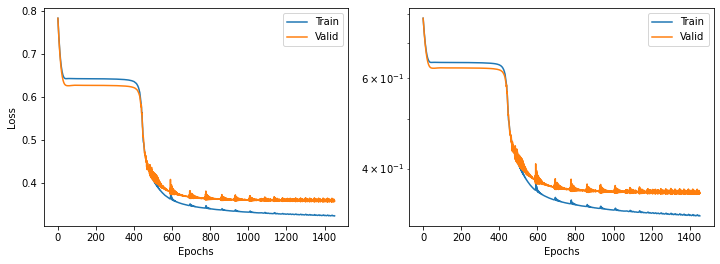

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(L_train, label='Train')
ax1.plot(L_valid, label='Valid')
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epochs')
ax1.legend()

ax2.semilogy(L_train, label='Train')
ax2.semilogy(L_valid, label='Valid')
ax2.set_xlabel('Epochs')
ax2.legend()

plt.show()

## Save/load model

At this point, you can opt to save the trained model.

Or, if you have previously trained and saved a model, you can skip the training and load the trained model here.

Here, I have stored a model instance that was trained with the full set of training data (~800 MB). You can just load it here. Again, to load it, you might need to have the right versions of PyG (2.0.4) and PyTorch (1.11.0).

In [9]:
# Save
# torch.save(model.to('cpu'), '/path/to/somewhere/filename.pt')

# Load
model = torch.load('./models/20221006-EGConv-r3.5.pt')
print(model)

EGCONV_GNN(dim=64, num_interactions=3, num_species=1, cutoff=3.5)


## Model inference on test datasets

We will apply the trained model to some atomic structures. But you will have to use external packages to read structure files and convert them to graphs. For these capabilities, I use `ase`.

Here, we will apply the model to a configuration of Al solid-liquid interface and save the output.

The inference time depends on whether GPU/accelerator is used, the compute speed of the machine, the scale of the atomic structure, etc. For the solid-liquid interface example, the inference should take only seconds.

In [16]:
from graphite.graph import atoms2graph
from torch_geometric.data import Data
import ase.io
from pathlib import Path

In [17]:
fname = Path('./data/solid-liquid-interface.poscar')
atoms = ase.io.read(fname)

edge_index, x, edge_attr = atoms2graph(atoms, cutoff=3.5, edge_dist=True)
data = Data(
    x          = torch.tensor(x,          dtype=torch.long),
    edge_index = torch.tensor(edge_index, dtype=torch.long),
    edge_attr  = torch.tensor(edge_attr,  dtype=torch.float),
)

model.eval()
model = model.to('cpu')
with torch.no_grad():
    pred = model(data).numpy()

atoms.info['cutoff'] = 3.5
atoms.arrays['sodas'] = pred.flatten()

ase.io.write(fname.with_suffix('.sodas-pred.extxyz'), atoms, format='extxyz')

The output, visualized with OVITO, is shown here:

![3D](./media/sl-interface-sodas-pred-3d.png)

Here's the 2D view:

![2D](./media/sl-interface-sodas-pred-2d.png)

The yellow region is crystalline and the dark purple region is liquid. It's nice to see a smooth transition between the two phases. It's the intended characteristic of SODAS.

This wraps up the demo for SODAS prediction. Please do contact the authors of this work if you have any questions or wish to see more features/applications to be implemented and uploaded to the repository. Thank you!